In [2]:
import numpy as np
import sys; sys.path.append('../')

from lib import FastGradientDescent
from lib import SinkhornMethod
from lib import LinearCouplingMethod
from lib import DualGradientDescent
from lib import Experiments

In [3]:
def fastgrad(C, p, q, gamma=0.1, eps=0.01, log=False):
    fgm = FastGradientDescent(gamma, n=p.shape[0], epsilon=eps)
    x, iterations_num = fgm.fit(C, p, q)
    return x, iterations_num, 0

def sinkhorn(C, p, q, gamma=0.1, eps=0.01, log=False):
    sm = SinkhornMethod(gamma, n=p.shape[0], epsilon=eps, log=log)
    x, inner_iterations_num, outer_iterations_num = sm.fit(C, p, q, with_prox=True)
    return x, inner_iterations_num, outer_iterations_num

def dualgrad(C, p, q, gamma=0.1, eps=0.01, log=False):
    sm = DualGradientDescent(gamma, eps, p.shape[0])
    x, inner_iterations_num = sm.fit(C, p, q)
    return x, inner_iterations_num, 0

In [ ]:
problems = []

for i in range(10, 20, 1):
    (C, p, q) = Experiments.load_data('test_data/1.png', 'test_data/2.png', show=i==15, size=i)
    problems.append((C, p, q))

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

def load_image(filename, basewidth):
        img = Image.open(filename)
        wpercent = (basewidth / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        img = img.resize((basewidth, hsize), Image.ANTIALIAS)
        return np.asarray(img, dtype="int32")

def load_data(img1_path='1.png', img2_path='2.png', show=False, size=10):
        img1 = Experiments.load_image(img1_path, size)[:, :, 1]
        img2 = Experiments.load_image(img2_path, size)[:, :, 1]

        C = np.zeros((img1.shape[0] * img1.shape[1], img1.shape[0] * img1.shape[1]))

        for i in range(img1.shape[0] * img1.shape[1]):
            for j in range(img1.shape[0] * img1.shape[1]):
                C[i, j] = np.linalg.norm(np.array([i // img1.shape[0], i % img1.shape[1]]) - np.array([j // img1.shape[0], j % img1.shape[1]]), 2)

        img1 += 1
        img2 += 1
        p = img1.reshape((img1.shape[0] * img1.shape[1], )) / np.sum(img1)
        q = img2.reshape((img2.shape[0] * img2.shape[1], )) / np.sum(img2)

        if show:
            plt.figure()
            plt.subplot(121)
            plt.imshow(img1, cmap='gray')
            plt.subplot(122)
            plt.imshow(img2, cmap='gray')
            plt.show()
        return C, p, q

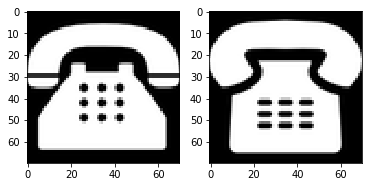

In [5]:
(C, p, q) = load_data('test_data/3.png', 'test_data/4.png', show=True, size=70)

In [6]:
max_gamma = 40
min_gamma = 2
stp_gamma = 1.5
epsilon = 0.01

epsilons, gammas, iterations = Experiments.test([(C, p, q)], 
                                                config={'eps': (epsilon, epsilon, 1), 
                                                        'gamma': (max_gamma, min_gamma, stp_gamma)},
                                                methods=[sinkhorn
#                                                          ,fastgrad,
#                                                          dualgrad
                                                        ])

100%|██████████| 8/8 [24:54<00:00, 287.86s/it]


In [7]:
import matplotlib.pyplot as plt

def plot_algorithm_comparation_pyplot(gammas, iterations, epsilon, n, gamma_star, save=False, methods_names=None):
        iters = iterations[0,:,0,:].reshape(1,-1).T
        epss = gammas
        n_methods = len(methods_names or [])
        
        plt.plot(epss.tolist() * n_methods, iters)
        plt.xlabel("$\gamma$")
        plt.ylabel("$N(\epsilon, \gamma)$")
        plt.title("$N(\epsilon, \gamma), \epsilon = %.2f$" % (epsilon) + "\n" + ", ".join(methods_names))
        
        plt.plot([gamma_star, gamma_star], [0, np.max(iters)], "r:", label="$\gamma^* = %.2e$" % gamma_star)
        gamma = 0
        for i in range(1, iters.shape[0]):
            if iters[i][0] / iters[i-1][0] > 1.5:
                gamma = epss[i]
                break
        plt.plot([gamma, gamma], [0, np.max(iters)], "g:", label="$\gamma = %.2e$" % gamma)
        if save:
            plt.savefig("plot_algorithm_comparation_pyplot.png", dpi=800)
        
        plt.legend()

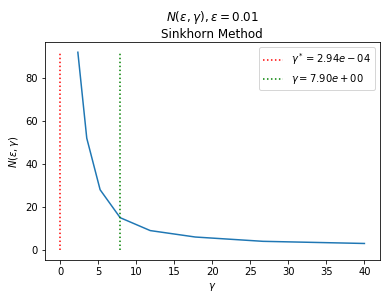

In [8]:
gamma_star = epsilon / (4 * np.log(p.shape[0]))

plot_algorithm_comparation_pyplot(gammas, iterations, epsilon, p.shape[0], gamma_star, save=True, methods_names=["Sinkhorn Method"
#                                                                                  , "Fast Gradient Method", "Dual Gradient Method"
                                                                                ])